In [44]:
# necessary imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from io import StringIO

# Loading Data

In [2]:
P = {} # df per Participant
data_dir = "clean_data"
for csv_file in os.listdir(data_dir):
    if csv_file.startswith("P"): # Only get Participant Directories
        pn = int(csv_file[1:-4])
        tmp = pd.read_csv(os.path.join(data_dir,csv_file))
        tmp["participant"] = pn
        P[pn] = tmp.dropna()
df = pd.concat(P.values(), axis = 0)# all data

In [3]:
P[1].sample()

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
112,2019-05-14 21:16:16.128000+09:00,YouTube,VIDEO_PLAYERS,70,NONE,34.305153,36.314952,163.399994,False,3,3,1,-1,1


In [4]:
df.sample()

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
3658,2019-05-06 13:24:12.451000+09:00,Facebook,SOCIAL,0.0,NONE,36.010727,35.175531,100.199997,False,2.0,0.0,2.0,2.0,72


In [5]:
df["uv_intensity"].unique()

array(['NONE', 'LOW', 'MEDIUM'], dtype=object)

In [6]:
df.isna().sum()

timestamp       0
app_name        0
app_category    0
brightness      0
uv_intensity    0
longitude       0
latitude        0
altitude        0
at_home         0
valence         0
arousal         0
attention       0
stress          0
participant     0
dtype: int64

In [7]:
df[df["at_home"] & (df["uv_intensity"]=='LOW')]

,timestamp,app_name,app_category,brightness,uv_intensity,longitude,latitude,altitude,at_home,valence,arousal,attention,stress,participant
527,2019-05-13 19:09:10.063000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316315,36.362699,82.900002,True,-2.0,-2.0,-2.0,3.0,3
528,2019-05-13 19:44:07.471000+09:00,Instagram,SOCIAL,13089.0,LOW,34.316315,36.362699,82.900002,True,-2.0,-2.0,-2.0,3.0,3
533,2019-05-14 04:55:36.218000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316304,36.362707,80.300003,True,-2.0,-2.0,-2.0,3.0,3
539,2019-05-14 09:49:13.220000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316295,36.362680,82.900002,True,-2.0,-2.0,-2.0,3.0,3
540,2019-05-14 10:45:05.119000+09:00,Facebook,SOCIAL,13089.0,LOW,34.316336,36.362685,73.900002,True,-2.0,-2.0,-2.0,3.0,3
2418,2019-05-03 12:34:46.717000+09:00,Instagram,SOCIAL,4553.0,LOW,34.324485,36.370946,0.000000,True,0.0,1.0,1.0,-3.0,55
2419,2019-05-03 12:34:48.016000+09:00,Instagram,SOCIAL,16756.0,LOW,34.324485,36.370946,0.000000,True,0.0,1.0,1.0,-3.0,55
418,2019-05-17 12:15:41.064000+09:00,Facebook,SOCIAL,47.0,LOW,34.314656,36.373763,95.000000,True,-2.0,-3.0,-1.0,1.0,39


In [8]:
df.groupby("app_category")["brightness"].mean().sort_values(ascending=False)

app_category
MUSIC_AND_AUDIO        402.823166
NEWS_AND_MAGAZINES     299.098655
BOOKS_AND_REFERENCE    156.969963
SOCIAL                 153.171821
GAME                   135.098287
VIDEO_PLAYERS          120.206874
LIBRARIES_AND_DEMO     116.788497
SHOPPING               108.100162
SPORTS                 106.200267
ENTERTAINMENT          105.808815
COMICS                  74.228095
Name: brightness, dtype: float64

# Descriptive Statistics

## Frequency Distribution

In [9]:
at_home_dist = df[df["at_home"]]["app_category"].value_counts() / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["app_category"].value_counts() / df[~df["at_home"]].shape[0]

In [10]:
dist_df = pd.DataFrame({"at_home":at_home_dist, "not_at_home":not_at_home_dist})
dist_df.sort_values(by=["at_home","not_at_home"], ascending=False)

,at_home,not_at_home
app_category,,
SOCIAL,0.434481,0.555846
VIDEO_PLAYERS,0.164932,0.067084
ENTERTAINMENT,0.101414,0.071903
BOOKS_AND_REFERENCE,0.095009,0.049625
GAME,0.063384,0.033265
MUSIC_AND_AUDIO,0.053910,0.066007
SHOPPING,0.033760,0.051182
COMICS,0.031625,0.091521
SPORTS,0.012944,0.007469


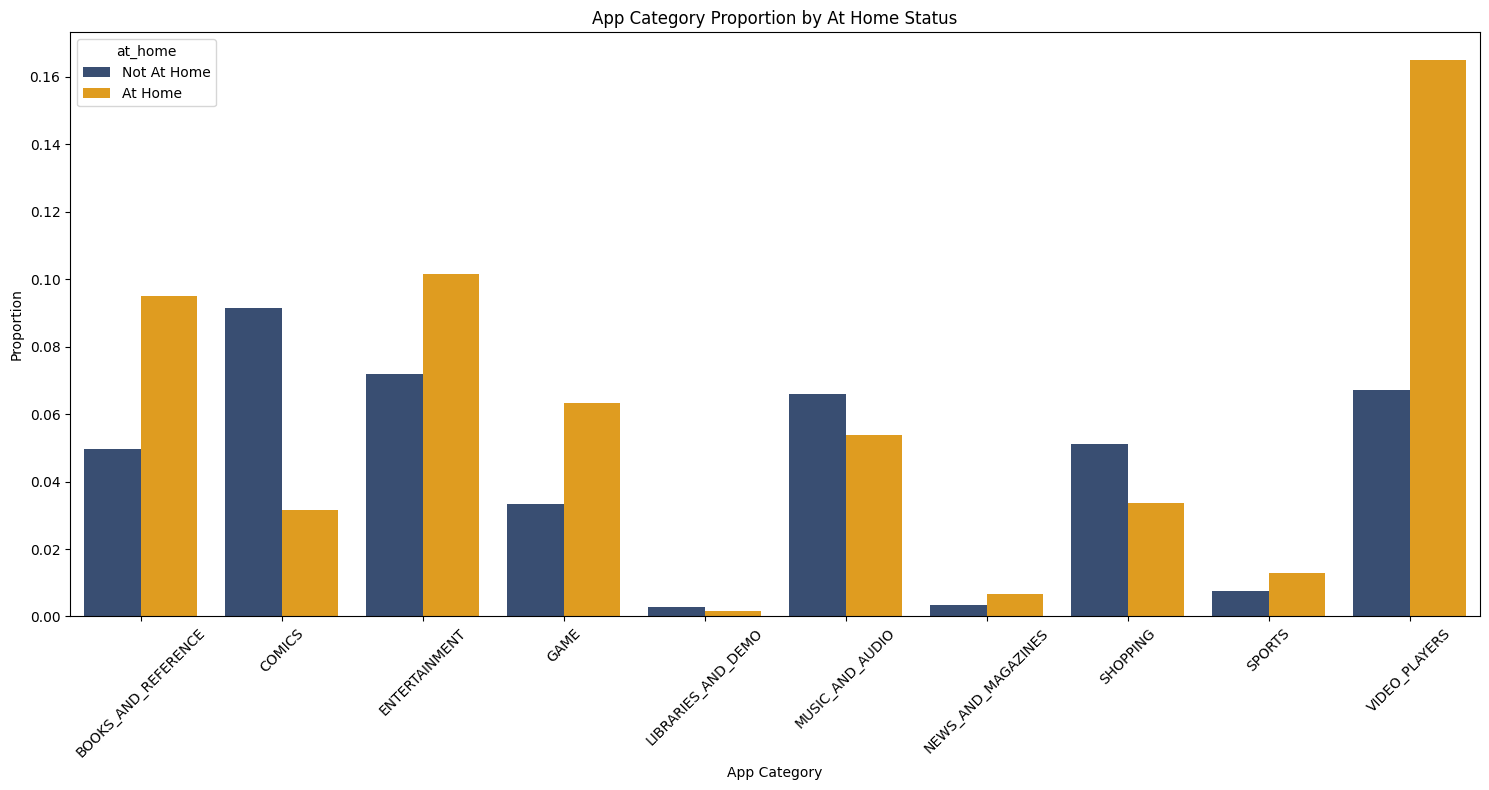

In [11]:

# Calculate the distributions
at_home_dist = df[df["at_home"]]["app_category"].value_counts()[1:] / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["app_category"].value_counts()[1:] / df[~df["at_home"]].shape[0]

# Create a DataFrame for plotting
dist_df = pd.DataFrame({
    'app_category': at_home_dist.index.tolist() + not_at_home_dist.index.tolist(),
    'proportion': at_home_dist.tolist() + not_at_home_dist.tolist(),
    'at_home': ['At Home'] * len(at_home_dist) + ['Not At Home'] * len(not_at_home_dist)
}).sort_values(by=["proportion"], ascending=False)

# Sort the DataFrame by app_category
dist_df = dist_df.sort_values(by=['app_category', 'at_home'], ascending=[True, False])

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='app_category', y='proportion', hue='at_home', data=dist_df, palette=['#2f4b7c', '#ffa600'])
plt.xlabel('App Category')
plt.ylabel('Proportion')
plt.title('App Category Proportion by At Home Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

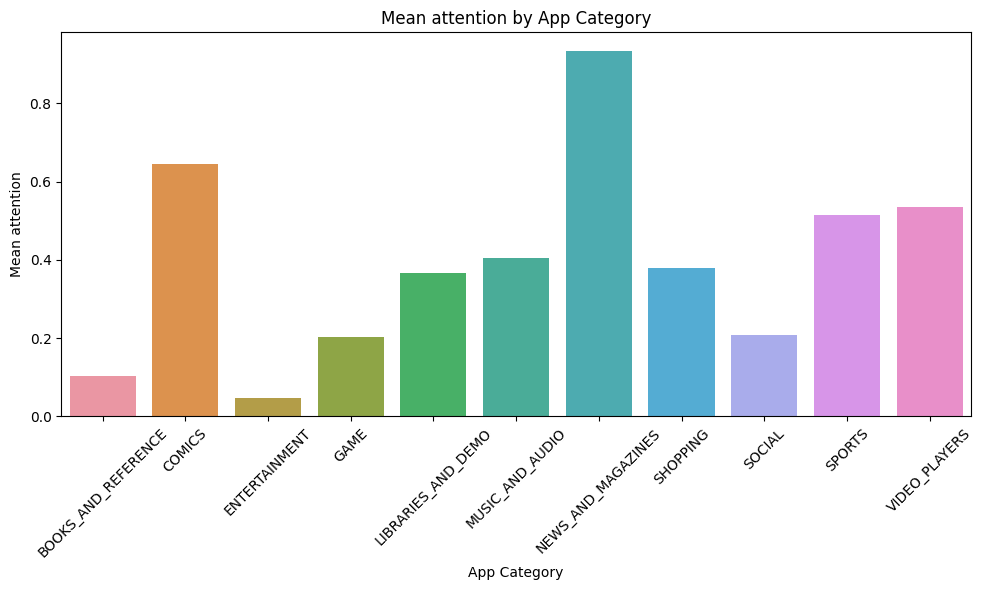

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

var = "attention"
# Group data by app_category and calculate mean stress
mean_stress_df = df.groupby("app_category")[var].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="app_category", y=var, data=mean_stress_df)  # No need for hue or palette
plt.xlabel("App Category")
plt.ylabel(f"Mean {var}")
plt.title(f"Mean {var} by App Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Chi square test of Independence

This test assesses if there's a statistically significant relationship between app category chosen and being at home or outdoors.

In [13]:
expected, observed, stats = pg.chi2_independence(df, "app_category", "at_home")
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,2137.405996,10.0,0.0,0.104674,1.0
1,cressie-read,0.666667,2030.249018,10.0,0.0,0.102016,1.0
2,log-likelihood,0.000000,1882.975080,10.0,0.0,0.098246,1.0
3,freeman-tukey,-0.500000,1825.534821,10.0,0.0,0.096736,1.0
4,mod-log-likelihood,-1.000000,1812.007096,10.0,0.0,0.096377,1.0
5,neyman,-2.000000,1930.966921,10.0,0.0,0.099490,1.0


### Logistic Regression (Interaction term?)
This model predicts the likelihood of experiencing high stress based on environment and app choice. The interaction term reveals if, for example, using social media outdoors leads to higher stress compared to using it at home.

In [14]:
enc = OneHotEncoder(sparse=False)
encoded_categories = enc.fit_transform(df[["app_category"]])

at_home_array = np.array(df["at_home"].astype(int))

X = np.column_stack((encoded_categories, at_home_array))


X.shape

(195080, 12)

## Fixed Effects Modles

In [38]:
results = {}
for emo_col in ["stress","valence","arousal","attention"]:
    dv = f"binary_{emo_col}"
    df[dv] = df[emo_col].apply(lambda x: 0 if x <=0 else 1)
    formula = f"{dv} ~ C(app_category) * at_home + C(participant)"
    results[emo_col] = smf.logit(formula=formula, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.502883
         Iterations 7
         Current function value: 0.537154
         Iterations: 35


/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.526096
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.582606
         Iterations 7


In [43]:
arousal_results_df = pd.read_html(results["arousal"].summary().tables[1].as_html(), header=0)[0]
arousal_results_df

/var/folders/1b/md1qw9955ql98bwdby4k7plm0000gn/T/ipykernel_59129/432538170.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  arousal_results_df = pd.read_html(results["arousal"].summary().tables[1].as_html(), header=0)[0]


,Unnamed: 0,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,0.5022,0.172,2.921,0.003,0.165,0.839
1,C(app_category)[T.1],-0.3828,0.032,-12.150,0.000,-0.445,-0.321
2,C(app_category)[T.2],-0.0773,0.031,-2.479,0.013,-0.138,-0.016
3,C(app_category)[T.3],0.2055,0.022,9.420,0.000,0.163,0.248
4,C(app_category)[T.4],0.1034,0.024,4.275,0.000,0.056,0.151
...,...,...,...,...,...,...,...
93,C(app_category)[T.6]:at_home[T.True],0.5250,0.105,5.002,0.000,0.319,0.731
94,C(app_category)[T.7]:at_home[T.True],-0.2395,0.122,-1.968,0.049,-0.478,-0.001
95,C(app_category)[T.8]:at_home[T.True],-1.4676,0.785,-1.871,0.061,-3.005,0.070
96,C(app_category)[T.9]:at_home[T.True],1.7418,0.276,6.311,0.000,1.201,2.283


In [42]:
results["arousal"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         binary_arousal   No. Observations:               195080
Model:                          Logit   Df Residuals:                   194982
Method:                           MLE   Df Model:                           97
Date:                Mon, 10 Jun 2024   Pseudo R-squ.:                  0.1977
Time:                        18:13:48   Log-Likelihood:            -1.0263e+05
converged:                       True   LL-Null:                   -1.2792e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.5022      0.172      2.921      0.003       0.165       0.839
C(app_category)[T.1]                     -0.3828      0.032    -12.150      0.000      -0.445      -0.321
C(app_category)[T.2]                     -0.0773      0.031     -2.479      0.013      -0.138      -0.016
C(app_category)[T.3]                      0.2055      0.022      9.420      0.000       0.163       0.248
C(app_category)[T.4]                      0.1034      0.024      4.275      0.000       0.056       0.151
C(app_category)[T.5]                     -0.1421      0.024     -6.001      0.000      -0.188      -0.096
C(app_category)[T.6]                     -0.1818      0.028     -6.607      0.000      -0.236      -0.128
C(app_category)[T.7]                      0.1539      0.031      5.019      0.000       0.094       0.214
C(app_category)[T.8]                      0.1936      0.091      2.134      0.033       0.016       0.371
C(app_category)[T.9]                     -0.2820      0.072     -3.931      0.000      -0.423      -0.141
C(app_category)[T.10]                    -0.3260      0.107     -3.053      0.002      -0.535      -0.117
at_home[T.True]                          -0.1855      0.045     -4.165      0.000      -0.273      -0.098
C(participant)[T.2]                      -1.4141      0.199     -7.093      0.000      -1.805      -1.023
C(participant)[T.3]                      -1.2166      0.192     -6.338      0.000      -1.593      -0.840
C(participant)[T.4]                      -1.9058      0.309     -6.167      0.000      -2.512      -1.300
C(participant)[T.5]                      -1.3617      0.183     -7.436      0.000      -1.721      -1.003
C(participant)[T.6]                       2.6505      0.196     13.514      0.000       2.266       3.035
C(participant)[T.7]                      -2.5310      0.175    -14.494      0.000      -2.873      -2.189
C(participant)[T.8]                       0.6354      0.180      3.526      0.000       0.282       0.989
C(participant)[T.9]                      -0.8523      0.175     -4.864      0.000      -1.196      -0.509
C(participant)[T.10]                     -0.1534      0.181     -0.849      0.396      -0.507       0.201
C(participant)[T.11]                     -0.4636      0.177     -2.615      0.009      -0.811      -0.116
C(participant)[T.12]                     -0.9850      0.179     -5.512      0.000      -1.335      -0.635
C(participant)[T.13]                     -0.3279      0.182     -1.804      0.071      -0.684       0.028
C(participant)[T.14]                      0.2508      0.235      1.066      0.286      -0.210       0.712
C(participant)[T.15]                     -0.5146      0.177     -2.903      0.004      -0.862      -0.167
C(participant)[T.16]                     -2.3391      0.182    -12.879      0.000      -2.695      -1.983
C(participant)[T.17]                      0.4118      0.175  

#### For Stress

In [15]:
df["binary_stress"] = df["stress"].apply(lambda x: 0 if x <=0 else 1)
formula = "binary_stress ~ C(app_category) * at_home + C(participant)"
res1 = smf.logit(formula=formula, data=df).fit()

Optimization terminated successfully.
         Current function value: 0.618708
         Iterations 6


In [37]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          binary_stress   No. Observations:               195080
Model:                          Logit   Df Residuals:                   195058
Method:                           MLE   Df Model:                           21
Date:                Mon, 10 Jun 2024   Pseudo R-squ.:                0.005623
Time:                        18:04:04   Log-Likelihood:            -1.2070e+05
converged:                       True   LL-Null:                   -1.2138e+05
Covariance Type:            nonrobust   LLR p-value:                2.765e-276
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -0.4165      0.021    -19.664      0.000      -0.458      -0.375
C(app_category)[T.COMICS]                                -0.3940      0.027    -14.664      0.000      -0.447      -0.341
C(app_category)[T.ENTERTAINMENT]                         -0.2028      0.028     -7.288      0.000      -0.257      -0.148
C(app_category)[T.GAME]                                  -0.3283      0.034     -9.547      0.000      -0.396      -0.261
C(app_category)[T.LIBRARIES_AND_DEMO]                     0.0787      0.091      0.865      0.387      -0.100       0.257
C(app_category)[T.MUSIC_AND_AUDIO]                       -0.1858      0.028     -6.562      0.000      -0.241      -0.130
C(app_category)[T.NEWS_AND_MAGAZINES]                    -0.0106      0.085     -0.125      0.901      -0.177       0.156
C(app_category)[T.SHOPPING]                               0.0191      0.030      0.643      0.520      -0.039       0.077
C(app_category)[T.SOCIAL]                                -0.4929      0.022    -22.143      0.000      -0.536      -0.449
C(app_category)[T.SPORTS]                                -0.8335      0.068    -12.327      0.000      -0.966      -0.701
C(app_category)[T.VIDEO_PLAYERS]                         -0.3263      0.029    -11.449      0.000      -0.382      -0.270
at_home[T.True]                                           0.2022      0.078      2.582      0.010       0.049       0.356
C(app_category)[T.COMICS]:at_home[T.True]                -0.0659      0.159     -0.415      0.679      -0.377       0.246
C(app_category)[T.ENTERTAINMENT]:at_home[T.True]         -0.2135      0.111     -1.928      0.054      -0.431       0.004
C(app_category)[T.GAME]:at_home[T.True]                   0.1196      0.125      0.955      0.339      -0.126       0.365
C(app_category)[T.LIBRARIES_AND_DEMO]:at_home[T.True]    -1.5692      0.778     -2.018      0.044      -3.093      -0.045
C(app_category)[T.MUSIC_AND_AUDIO]:at_home[T.True]       -0.6985      0.140     -4.978      0.000      -0.974      -0.424
C(app_category)[T.NEWS_AND_MAGAZINES]:at_home[T.True]    -0.3812      0.314     -1.213      0.225      -0.997       0.235
C(app_category)[T.SHOPPING]:at_home[T.True]              -0.0833      0.151     -0.553      0.580      -0.378       0.212
C(app_category)[T.SOCIAL]:at_home[T.True]                -0.0606      0.087     -0.696      0.487      -0.231       0.110
C(app_category)[T.SPORTS]:at_home[T.True]                -0.7320      0.306     -2.391      0.017      -1.332      -0.132
C(app_category)[T.VIDEO_PLAYERS]:at_home[T.True]         -0.2263      0.101     -2.237      0.025      -0.425      -0.028
=========================================================================================================================
"""

In [16]:
binary_stress = df["stress"].apply(lambda x: 0 if x <=0 else 1)
y = np.array(binary_stress)

In [17]:
for category in df["app_category"].unique():
    print(category, len(df[df["app_category"]==category]["app_name"].unique()))
    print("\n", df[df["app_category"]==category]["app_name"].unique())

SOCIAL 32

 ['Facebook' '에브리타임' 'Between' 'Instagram' 'BAND' '커플릿' '네이버 카페' '네이버 블로그'
 '카카오스토리' 'brunch' '다음카페' '트위터' '당근마켓' 'Lysn' 'Lite' 'Zenly' '씀' '1km'
 'FANDOM' 'Cyworld' '캐시슬라이드' '디시인사이드' 'Reddit' '스카이피플' 'Vingle' '스푼 라디오'
 '헬로우봇' 'pixiv' 'Dreamclass' '캠퍼스팅' '스와이프' '아만다']
SHOPPING 49

 ['쿠팡' 'MUSINSA' '롯데홈쇼핑' '아이디어스' '코디북' '지그재그' '옷잘남' '11번가' '위메프' '티몬'
 'AliExpress' '원더쇼핑' '에스티엘' '이랜드몰' '롯데면세점' '11번가쇼킹딜' '엽기떡볶이' '오먹상점' '다이소몰'
 '번개장터' '헬로마켓' '오늘의집' '올리브영' '안다르' 'G마켓' 'LFmall' '옥션' '키작은남자' 'SSG.COM'
 '에이블리' '브랜디' '인터파크' '이마트몰' '중고나라' '메이비베이비' 'W Concept' '手机淘宝' '디코드'
 '다나와 가격비교' '29CM' '서울스토어' '크루비' 'StyleShare' '리리앤코' 'LookPin' '시크릿라벨'
 'Qoo10' '몰테일' 'Amazon Shopping']
BOOKS_AND_REFERENCE 20

 ['NAVER' '시리즈' '나무위키뷰어' '위키백과' '성경일독Q' '성경' '알라딘' '문피아' '네이트' 'Big Finish'
 '원스토어 북스' '예스24 도서' '모바일교보문고' '리디북스' '웹소설 조아라' 'Google Play 북' '네이버 앱스토어'
 'Amazon Kindle' '프라임 영한한영' '텍뷰']
COMICS 5

 ['네이버 웹툰' '다음웹툰' '라프텔' 'Perfect Viewer' '레진코믹스']
VIDEO_PLAYERS 13

 ['YouTube' 'oksusu' 'MX 플레이

#### For arousal

In [19]:
binary_arousal = df["arousal"].apply(lambda x: 0 if x <=0 else 1)
y = np.array(binary_arousal)

fixed effects model (assume similartiy of data points per particant
                    rport effects size and post hoc in depth explanation on results we got)

In [20]:
log_r = pg.logistic_regression(X=X,y=y)
log_r["names"] = ["Intercept"] + list(enc.categories_[0]) + ["AT_HOME"]
log_r

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,-0.361309,0.011632,-31.061263,8.038241e-212,-0.384108,-0.338510
1,BOOKS_AND_REFERENCE,-0.551245,0.023308,-23.650708,1.160675e-123,-0.596928,-0.505563
2,COMICS,0.590998,0.018129,32.599929,4.110707e-233,0.555466,0.626530
3,ENTERTAINMENT,-0.657970,0.020868,-31.530710,3.296839e-218,-0.698869,-0.617070
4,GAME,-0.068999,0.025605,-2.694775,7.043622e-03,-0.119183,-0.018815
5,LIBRARIES_AND_DEMO,0.406045,0.079512,5.106735,3.277728e-07,0.250205,0.561886
6,MUSIC_AND_AUDIO,-0.160464,0.020333,-7.891964,2.974684e-15,-0.200315,-0.120613
7,NEWS_AND_MAGAZINES,0.069258,0.072358,0.957164,3.384845e-01,-0.072560,0.211077
8,SHOPPING,-0.657067,0.023854,-27.545833,4.964374e-167,-0.703820,-0.610315
9,SOCIAL,-0.259720,0.012974,-20.018559,3.795421e-89,-0.285149,-0.234292


#### For attention

In [21]:
binary_attention = df["attention"].apply(lambda x: 0 if x <=0 else 1)
y = np.array(binary_attention)

In [22]:
log_r = pg.logistic_regression(X=X,y=y)
log_r["names"] = ["Intercept"] + list(enc.categories_[0]) + ["AT_HOME"]
log_r

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,0.020498,0.011753,1.744051,8.115021e-02,-0.002538,0.043533
1,BOOKS_AND_REFERENCE,-0.518569,0.022150,-23.411886,3.234098e-121,-0.561981,-0.475156
2,COMICS,0.335150,0.018309,18.305586,7.468444e-75,0.299266,0.371034
3,ENTERTAINMENT,-0.407989,0.019485,-20.938879,2.369698e-97,-0.446178,-0.369799
4,GAME,-0.197268,0.025247,-7.813540,5.560356e-15,-0.246752,-0.147785
5,LIBRARIES_AND_DEMO,-0.264603,0.080081,-3.304197,9.524881e-04,-0.421559,-0.107647
6,MUSIC_AND_AUDIO,-0.189275,0.019989,-9.468811,2.830480e-21,-0.228453,-0.150097
7,NEWS_AND_MAGAZINES,0.567920,0.074651,7.607682,2.790551e-14,0.421607,0.714233
8,SHOPPING,0.097963,0.021833,4.486909,7.226394e-06,0.055171,0.140754
9,SOCIAL,-0.222457,0.012976,-17.143421,7.038480e-66,-0.247890,-0.197024


#### For valence

In [23]:
binary_valence = df["valence"].apply(lambda x: 0 if x <=0 else 1)
y = np.array(binary_valence)

In [24]:
log_r = pg.logistic_regression(X=X,y=y)
log_r["names"] = ["Intercept"] + list(enc.categories_[0]) + ["AT_HOME"]
log_r

,names,coef,se,z,pval,CI[2.5%],CI[97.5%]
0,Intercept,0.250853,0.011678,21.480654,2.361559e-102,0.227964,0.273742
1,BOOKS_AND_REFERENCE,-0.636080,0.021922,-29.016261,4.103018e-185,-0.679046,-0.593115
2,COMICS,0.203317,0.018367,11.069641,1.761040e-28,0.167318,0.239316
3,ENTERTAINMENT,0.218844,0.019555,11.191425,4.491576e-29,0.180517,0.257170
4,GAME,0.213203,0.025678,8.302880,1.016175e-16,0.162875,0.263532
5,LIBRARIES_AND_DEMO,0.112360,0.080788,1.390795,1.642876e-01,-0.045982,0.270702
6,MUSIC_AND_AUDIO,-0.016656,0.019990,-0.833221,4.047200e-01,-0.055836,0.022524
7,NEWS_AND_MAGAZINES,-0.160250,0.071617,-2.237589,2.524784e-02,-0.300618,-0.019883
8,SHOPPING,-0.316545,0.021772,-14.538907,6.868085e-48,-0.359218,-0.273873
9,SOCIAL,-0.140563,0.012900,-10.896511,1.197618e-27,-0.165846,-0.115280


### Means and Standard Deviations

In [25]:
df.describe()

,brightness,longitude,latitude,altitude,valence,arousal,attention,stress,participant,binary_stress
count,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000,195080.000000
mean,154.032161,34.296887,36.415838,80.737653,0.608222,-0.192460,0.279188,-0.454731,41.160642,0.313928
std,1157.189753,2.314209,0.352158,28.407890,1.333983,1.554563,1.562764,1.562909,22.036558,0.464089
min,0.000000,-243.254757,35.096366,-132.824455,-3.000000,-3.000000,-3.000000,-3.000000,1.000000,0.000000
25%,3.000000,34.314669,36.368086,75.000000,0.000000,-2.000000,-1.000000,-2.000000,21.000000,0.000000
50%,29.000000,34.316049,36.370716,84.599998,1.000000,0.000000,0.000000,-1.000000,43.000000,0.000000
75%,83.000000,34.320555,36.373941,95.300003,2.000000,1.000000,1.000000,1.000000,57.000000,1.000000
max,65535.000000,36.250271,37.709008,1151.584606,3.000000,3.000000,3.000000,3.000000,80.000000,1.000000


# Inferential Statistics

A. Chi-Square Test of Independence

    Objective: To test if there is an association between the environmental setting (home vs. outdoors) and the type of app used.
    Variables:
        Independent Variable: Environmental Setting (Home vs. Outdoors)
        Dependent Variable: Type of App (Games, Social Media, Classic Entertainment)
    Test: Chi-Square Test of Independence.

B. Multinomial Logistic Regression

    Objective: To examine the influence of environmental setting on the likelihood of choosing different types of apps while controlling for other variables.
    Variables:
        Dependent Variable: Type of App (categorical with three levels: Games, Social Media, Classic Entertainment)
        Independent Variables: Environmental Setting, Stress Levels, Valence, Arousal, Attention
    Test: Multinomial Logistic Regression.

C. t-Tests and ANOVA

    Objective: To compare the stress levels, valence, and arousal between different settings and app types.
    Tests:
        t-Tests: Compare mean stress levels, valence, and arousal between two groups (home vs. outdoors).
        ANOVA: Compare mean stress levels, valence, and arousal across multiple groups (different app types).

D. Mixed-Effects Model

    Objective: To account for the repeated measures design, considering that multiple observations come from the same participants.
    Variables:
        Fixed Effects: Environmental Setting, Type of App
        Random Effects: Participant ID
        Dependent Variables: Stress Levels, Valence, Arousal
    Test: Mixed-Effects Model.

# Correlation and Mediation Analysis

A. Correlation Analysis

    Objective: To explore the relationships between stress levels, valence, arousal, and app usage in different settings.
    Variables: Stress Levels, Valence, Arousal, Type of App, Environmental Setting
    Test: Pearson or Spearman Correlation Coefficients.

B. Mediation Analysis

    Objective: To examine if the relationship between environmental setting and stress levels is mediated by the type of app used.
    Variables:
        Independent Variable: Environmental Setting
        Mediator: Type of App
        Dependent Variable: Stress Levels
    Test: Mediation Analysis using regression techniques.

In [26]:
df["app_category"].unique()

array(['SOCIAL', 'SHOPPING', 'BOOKS_AND_REFERENCE', 'COMICS',
       'VIDEO_PLAYERS', 'MUSIC_AND_AUDIO', 'ENTERTAINMENT', 'GAME',
       'LIBRARIES_AND_DEMO', 'SPORTS', 'NEWS_AND_MAGAZINES'], dtype=object)

In [27]:
df.isna().sum()

timestamp        0
app_name         0
app_category     0
brightness       0
uv_intensity     0
longitude        0
latitude         0
altitude         0
at_home          0
valence          0
arousal          0
attention        0
stress           0
participant      0
binary_stress    0
dtype: int64

In [28]:
cat_to_num ={'SOCIAL': 0,
             'SHOPPING': 1,
             'BOOKS_AND_REFERENCE': 2,
             'COMICS': 3,
             'VIDEO_PLAYERS': 4,
             'MUSIC_AND_AUDIO': 5,
             'ENTERTAINMENT': 6,
             'GAME': 7,
             'LIBRARIES_AND_DEMO': 8,
             'SPORTS': 9,
             'NEWS_AND_MAGAZINES': 10}
df['app_category'] = df['app_category'].apply(lambda x: cat_to_num[x])

df["app_category"]=df["app_category"].astype('category')
df["participant"]=df["participant"].astype('category')
df["at_home"]=df["at_home"].astype('category')

In [29]:
pg.rm_anova(data=df, dv="stress",within=["app_category"],subject="participant")

ValueError: cannot convert float NaN to integer

In [ ]:
for col in df.columns:
    print(df[col].unique())

In [ ]:
pg.rm_anova(data=P[3], dv="stress",within=["app_category"],subject="participant")

In [ ]:
df.columns

In [ ]:
AnovaRM(data=df,depvar="stress", within = ["app_category"], subject="participant",aggregate_func="mean")

In [ ]:
df.groupby("participant")["app_category"].count().sort_values()[23:]